# Einleitung zum Versuch "Calibration Correction"

In diesem Versuch liegt der Schwerpunkt auf der Kalibrierung von CO‚ÇÇ Sensoren. Diese Sensoren liefern h√§ufig Messwerte, die durch Offsets verf√§lscht sind. Eine pr√§zise Kalibrierung ist daher unerl√§sslich, um zuverl√§ssige und wissenschaftlich verwertbare Ergebnisse zu erhalten.

## Hintergrund und Motivation

Sensoren sind in der Praxis oft verschiedenen St√∂reinfl√ºssen ausgesetzt, die ihre Messgenauigkeit beeintr√§chtigen k√∂nnen. Ohne entsprechende Korrekturen k√∂nnen die erfassten Daten zu Fehlinterpretationen f√ºhren. In unserem Versuch wird deshalb zun√§chst eine einfache 1-Punkt-Kalibrierung durchgef√ºhrt, um den systematischen Offset zu ermitteln. Anschlie√üend erfolgt eine 2-Punkt-Kalibrierung, bei der sowohl der Slope und der Intercept bestimmt werden. Diese Methode erm√∂glicht es, Messwerte √ºber den gesamten Dynamikbereich des Sensors korrekt zu adjustieren.

In [4]:
import polars as pl
import os
import sys

# Add the parent directory to the system path
PROJECT_PATH = os.path.abspath(os.path.join(".."))

if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)
    
from utils.plot_dataframes import plot_column, plot_columns, plot_column_difference
from utils.process_bottles import trim_rows, median_and_mean

In [5]:
df_p = pl.read_parquet("../data/1_Calibration_Correction/Reference_Picarro_G2401.parquet")
df_s = pl.read_parquet("../data/1_Calibration_Correction/Sensor_GMP343_Measurement.parquet")
df_c = pl.read_parquet("../data/1_Calibration_Correction/Sensor_GMP343_Calibration.parquet")

In [6]:
df = df_s.join(df_p, on="datetime", how="left")

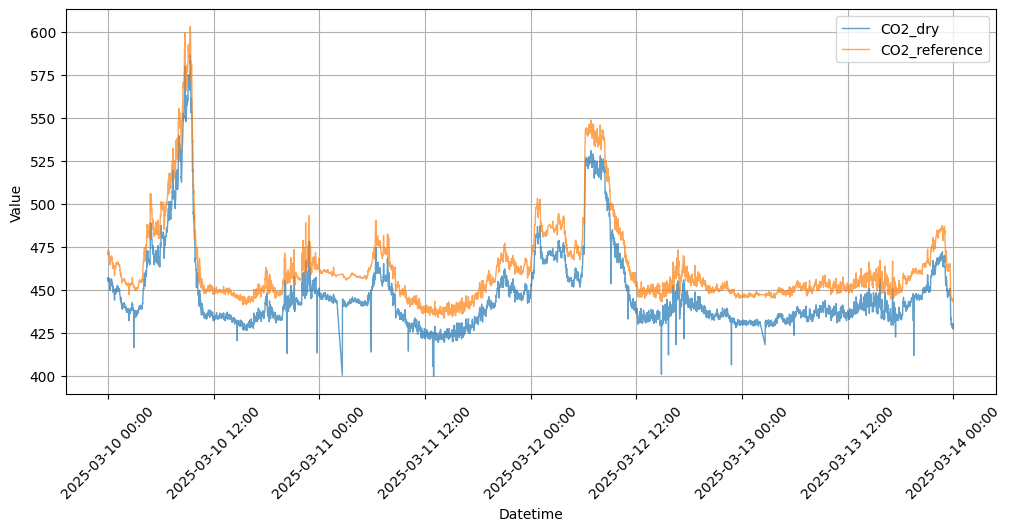

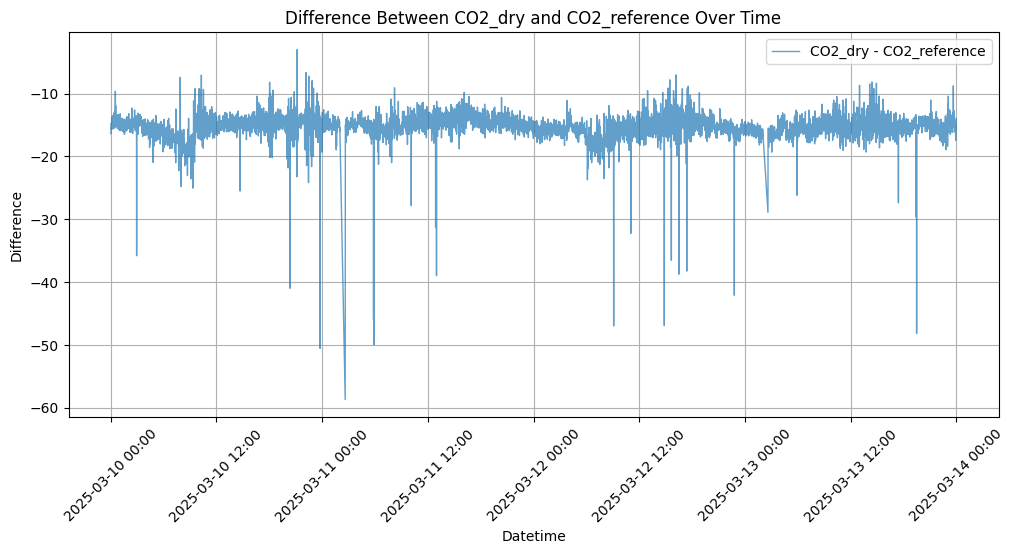

In [7]:
plot_columns(df,"datetime",["CO2_dry", "CO2_reference"])
plot_column_difference(df,"datetime",["CO2_dry", "CO2_reference"])

---

## Erkl√§rung zu Ausrei√üern in Bild 2

Die starken Ausrei√üer (10 ppm und mehr) in Bild 2 werden durch Power Resets des CO2 Sensors verursacht. Diese Resets sind notwendig, wenn der Sensor sich in einem Zustand befindet, der eine korrekte Messung nicht mehr zul√§sst. In solchen F√§llen wird der Sensor zur√ºckgesetzt, um ihn wieder in einen betriebsbereiten Zustand zu versetzen. Beim Aufstart sendet der Sensor kurzeitig falsche Messungen. Im Notebook 2 werden wir eine Methode kennenlernnen, um diese Ausrei√üer zu identifizieren und zu entfernen. Bis dahin werden wird die Ausrei√üer in Bild 2 nicht weiter beachten. Wir konzentrieren uns zun√§chst auf die Kalibrierung des Sensors, sodass die Unterschied zwischen Sensor und Referenzmessung m√∂glichst nahe 0 sind. 

---

# Offset-Korrektur

Die Offset-Korrektur ist eine grundlegende Methode, um konstante Messabweichungen zu korrigieren ‚Äì insbesondere, wenn die CO‚ÇÇ-Werte nahe dem Basiswert liegen. Dabei wird ein fester Fehlerwert, der sogenannte Offset, von den Messwerten abgezogen, um den tats√§chlichen CO‚ÇÇ-Gehalt zu ermitteln.

## Grundlagen der Offset-Korrektur

Bei der Offset-Korrektur wird angenommen, dass der Sensor einen konstanten Fehler aufweist. Die Korrektur erfolgt, indem der Offset von allen gemessenen Werten subtrahiert wird. Die grundlegende Formel lautet:

$$
\text{Korrigierter Wert} = \text{Gemessener Wert} - \text{Offset}
$$

Der Offset wird dabei typischerweise durch Messungen gegen eine Referenz bestimmt.

## Experimentelle Vorgehensweise

Bevor komplexere Kalibrierverfahren angewendet werden, experimentiert bitte selbstst√§ndig mit der Offset-Korrektur. Ziel ist es, ein fundiertes Verst√§ndnis daf√ºr zu entwickeln, wie der Offset die Messwerte beeinflusst und warum er korrigiert werden muss:

**Anwendung der Offset-Korrektur:**
   - Subtrahiert den ermittelten Offset von allen zuk√ºnftigen Messwerten.
   - Beobachtet, wie sich die korrigierten Werte im Vergleich zu den erwarteten Werten verhalten.

# üß™ Praktiksche √úbung 1

In dieser √úbung wollen wir ein Gef√ºhl f√ºr den Offset entwickeln, indem wir diesen St√ºck f√ºr St√ºck anpassen, um eine passende Korrektur f√ºr unsere Sensordaten zu erhalten.

‚úÖ Aufgabe:

- Ver√§ndere den Parameter `offset`, bis eine gute Korrektur der Daten sichtbar wird. 

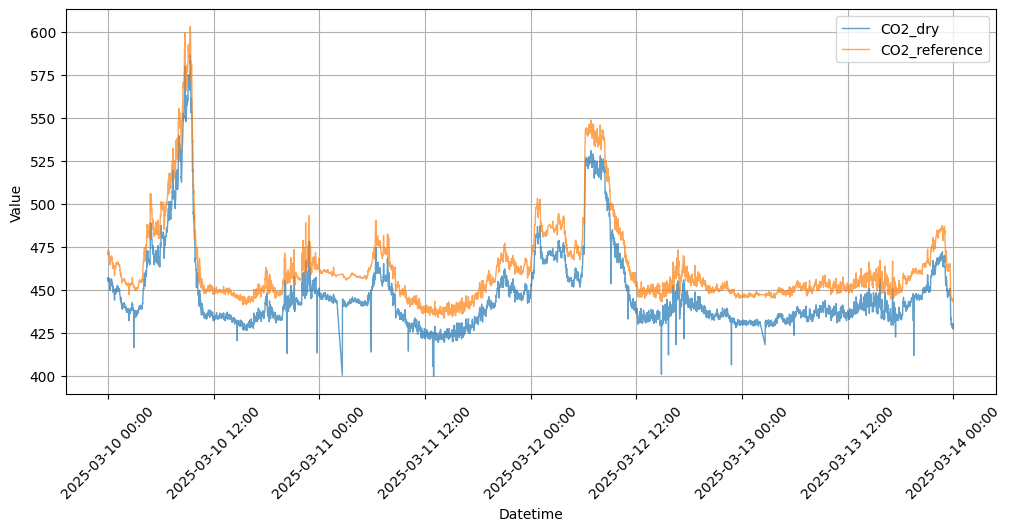

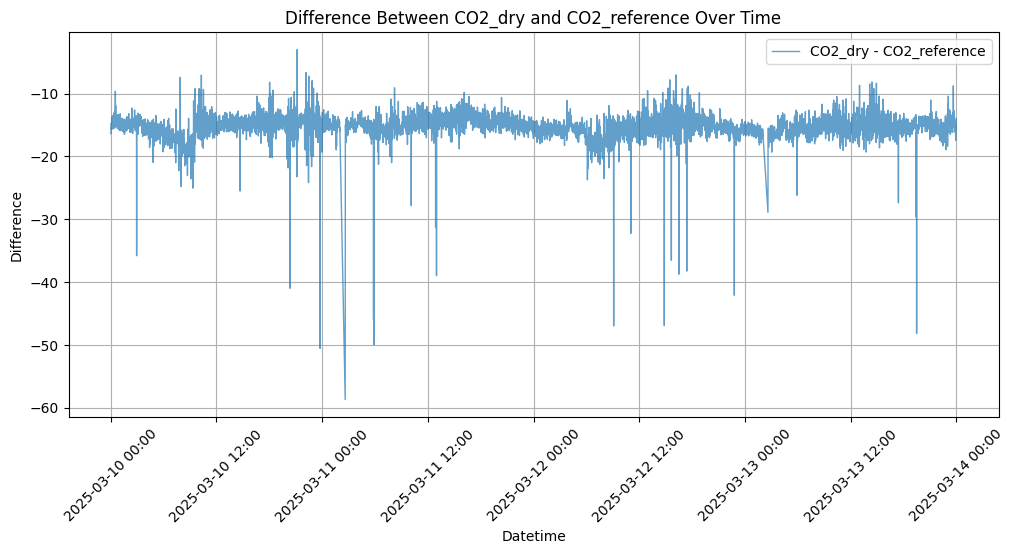

In [9]:
## Ver√§ndere nachfolgende Parameter
offset = 0
##

df_plot = df.with_columns(pl.col("CO2_dry") - offset)

plot_columns(df_plot,"datetime",["CO2_dry", "CO2_reference"])
plot_column_difference(df_plot,"datetime",["CO2_dry", "CO2_reference"])

## Fragen:

- Welchen Offset habt ihr final ausgew√§hlt? 
  
- Wieso habt ihr diesen Offset ausgew√§hlt?

- Wieso funktioniert die Korrektur an manchen Zeitpunkten besser und an anderen schlechter?


---

# Umstellung von Offset-Korrektur zur Zweipunktkalibrierung

Wir wechseln von der einfachen Offset-Korrektur zur Zweipunktkalibrierung. Wie ihr zuvor gesehen habt, passt die Offset-Korrektur an manchen Stellen gut (Wertebereich: 425-450ppm), an anderen (Wertebereich: 500-600ppm) jedoch nicht. Dies liegt daran, dass die Offset-Korrektur nur einen konstanten Fehler ber√ºcksichtigt. Bei h√∂heren CO‚ÇÇ-Werten zeigt sich, dass der Sensor mit einem anderen Offset korregiert werden muss. Daher ist eine einfache Offset-Korrektur nicht ausreichend.

## Warum die Umstellung?

Bisher haben wir eine Offset-Korrektur angewendet, die den Sensorfehler durch eine konstante Verschiebung kompensiert. Diese Methode ist dann effektiv, wenn die CO‚ÇÇ-Werte nahe am Basiswert liegen. Steigen die Werte jedoch deutlich an, wird sichtbar, dass der Sensor nicht nur einen konstanten Fehler aufweist, sondern auch in seiner Skalierung abweicht. Die einfache Offset-Korrektur ber√ºcksichtigt diese Skalierungsproblematik nicht, was zu Ungenauigkeiten f√ºhrt.

## Korrekturfunktion

Wir gehen davon aus, dass diese Fehler √ºber den betrachteten Wertebereich linear sind. Das bedeutet, dass der Offset sich linear mit dem CO‚ÇÇ-Gehalt √§ndert. Die Korrektur erfolgt durch eine Geradenfunktion (y = mx + b). 

## Funktionsweise der Zweipunktkalibrierung

Die Zweipunktkalibrierung bestimmt den Offset an zwei Punkten, um die zwei unbekannten Parameter **$m$** (Slope) und **$b$** (Intercept) ermitteln zu k√∂nnen. Klassischerweise werden die Punkte an beiden Enden des Messbereichs gew√§hlt, um eine m√∂glichst pr√§zise Kalibrierung zu gew√§hrleisten. Hier w√§re dies z.B. bei etwa 400 ppm und 600 ppm.

- **Low Value:** Ein bekannter Wert, leicht unterhalb des Messbereichs
- **High Value:** Ein zweiter Wert, leicht oberhalb des Messbereichs

Aus diesen beiden Referenzwerten l√§sst sich eine lineare Kalibrierungsgleichung ableiten:

$$
\text{Korrigierter Wert} = m \times (\text{Gemessener Wert}) + b
$$

wobei:
- **$m$** den Skalierungsfaktor (Steigung) darstellt,
- **$b$** den zu korrigierenden Offset bei 0 ppm (y-Achsenabschnitt) beschreibt.

## Experimentelle Vorgehensweise

Bevor Kalibrierflaschen zur Bestimmung der Parameter eingesetzt werden, experimentiert bitte selbstst√§ndig mit den Werten f√ºr **$m$** (Slope) und **$b$** (Intercept). Ziel ist es, ein Gef√ºhl  dar√ºber zu entwickeln, wie gro√ü diese Parameter etwa sein m√ºssen, um eine gute Kalibrierung zu erreichen.

1. **Verst√§ndnis der Parameter:**
   - **Slope ($m$):** Dieser Faktor bestimmt, wie stark sich der gemessene Wert in Relation zur tats√§chlichen CO‚ÇÇ-Konzentration ver√§ndert. Ein zu geringer Slope f√ºhrt dazu, dass hohe Konzentrationen nicht ausreichend abgebildet werden, w√§hrend ein zu hoher Slope die √Ñnderungen √ºberbetont.
   - **Intercept ($b$):** Dieser Parameter korrigiert die Basisverschiebung des Sensors. Ein falsch eingestellter Intercept bewirkt, dass die Messwerte dauerhaft nach oben oder unten verschoben sind, selbst wenn die Skalierung stimmt.

2. **Eigene Experimente durchf√ºhren:**
   - Variiert **$m$** und **$b$** an euren Messdaten und beobachtet, wie sich die Kalibrierung ver√§ndert.
   - Vergleicht eure Ergebnisse mit den bekannten Referenzwerten und versucht herauszufinden, welche Kombination am besten passt.


# Visualisierung

Hier ist die zeitliche Information entfernt und die Messwerte nach x aufsteigend sortiert dargestellt. Die blaue Linie sind die rohen Messwerte gemessen durch den Sensor, die braune Linie die Messwerte nach der Korrektur.
Ihr seht, dass abh√§ngig von der Gr√∂√üe des Wertes X, die Korrektur unterschiedlich stark ausf√§llt (blaue Pfeile). 

<img src="../pictures/2pt_calibration_fct.jpg" alt="2pt calibration" width="600"/>

Source: https://www.dracal.com/wp-content/uploads/2022/06/2pt_calibration_fct.png


# üß™ Praktiksche √úbung 2

In dieser √úbung wollen wir ein Gef√ºhl f√ºr die Parameter Intercept und Slope entwickeln, indem wir diese St√ºck f√ºr St√ºck anpassen, um eine passende Korrektur f√ºr unsere Sensordaten zu erhalten.

‚úÖ Aufgabe:

- Ver√§ndere die Parameter `intercept` und `slope`, bis eine gute Korrektur der Daten sichtbar wird. 

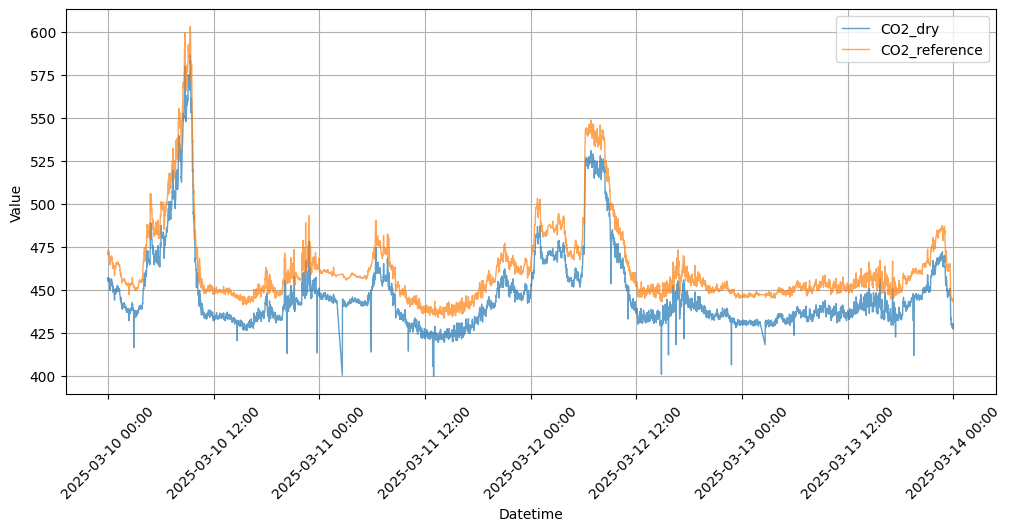

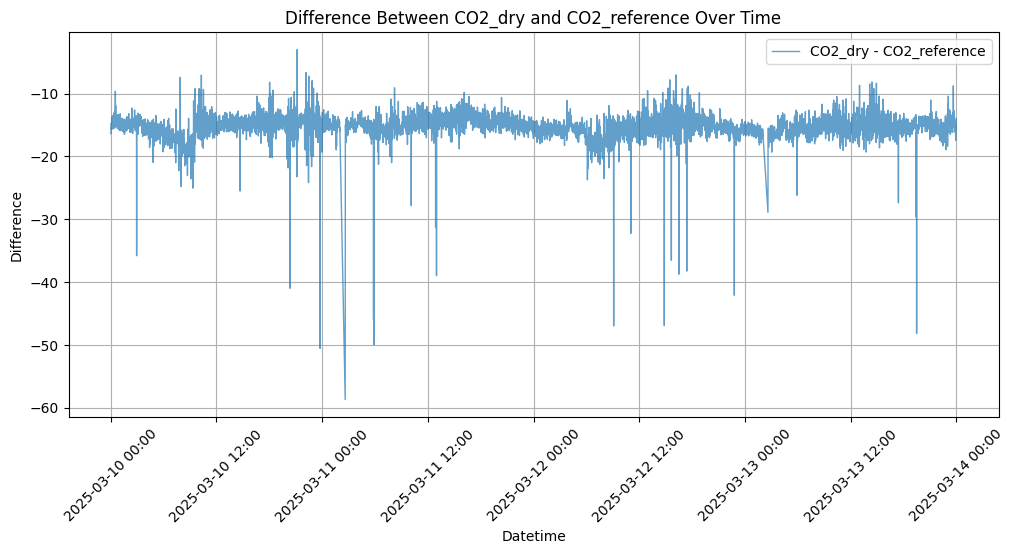

In [11]:
## Ver√§ndere nachfolgende Parameter
intercept = 0
slope = 1
##

df_plot = df.with_columns(pl.col("CO2_dry") * slope + intercept)

plot_columns(df_plot,"datetime",["CO2_dry", "CO2_reference"])
plot_column_difference(df_plot,"datetime",["CO2_dry", "CO2_reference"])

In [ ]:
# Betrachtet nun die Differenz "diff" zwischen den beiden Sensoren. Habt ihr die Korrektur gut getroffen?
print(df_plot.with_columns(diff = pl.col("CO2_dry") - pl.col("CO2_reference")).select(pl.col("diff")).describe())

shape: (9, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ diff       ‚îÇ
‚îÇ ---        ‚îÜ ---        ‚îÇ
‚îÇ str        ‚îÜ f64        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count      ‚îÜ 5691.0     ‚îÇ
‚îÇ null_count ‚îÜ 0.0        ‚îÇ
‚îÇ mean       ‚îÜ -15.285223 ‚îÇ
‚îÇ std        ‚îÜ 2.278631   ‚îÇ
‚îÇ min        ‚îÜ -58.730373 ‚îÇ
‚îÇ 25%        ‚îÜ -16.101266 ‚îÇ
‚îÇ 50%        ‚îÜ -15.169193 ‚îÇ
‚îÇ 75%        ‚îÜ -14.271651 ‚îÇ
‚îÇ max        ‚îÜ -2.974747  ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


Fragen:

- Welchen Slope und Intercept habt ihr ausgew√§hlt?

- Was ist eine gute Taktik um den Slope und Intercept schnell bestimmen zu k√∂nnen?

# Bestimmung anhand von Kalibrierflaschen

Nachfolgend seht ihr einen Kalibriervorgang mit Kalibrierflaschen. Diese sind mit tockener Luft und einer bekannten CO‚ÇÇ-Konzentration gef√ºllt und dienen dazu, den Sensor pr√§zise zu kalibrieren.

Der Kalibrierprozess erfolgt sequentiell, wobei die erste Kalibrierflasche l√§nger aktiv ist. Die Kalibrierflaschen werden √ºber elektronische Magnetventil zugeschalten, w√§hrend der Hauptkanal geschlossen wird. Um Gas von den Kalibrierflaschen zu entnehmen, muss ein Unterdruck durch die Pumpe angelegt werden.

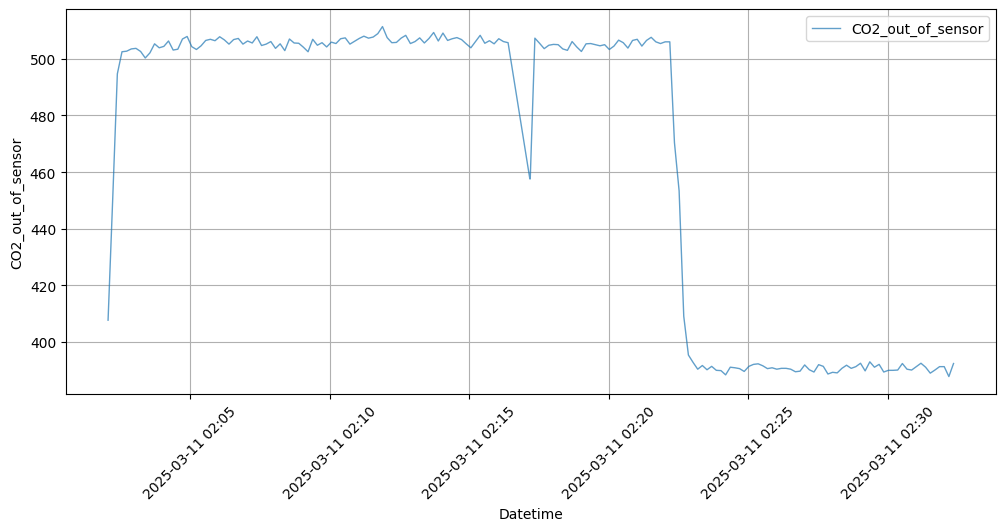

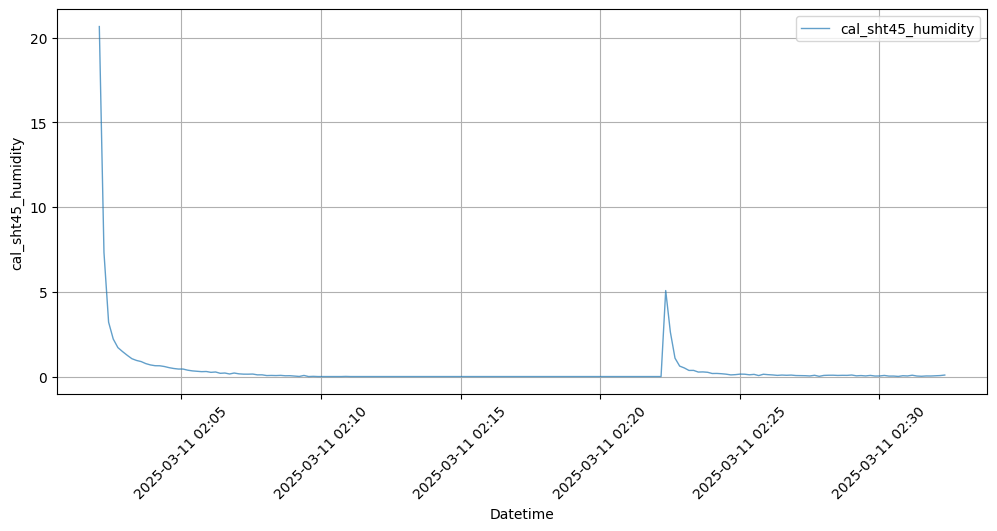

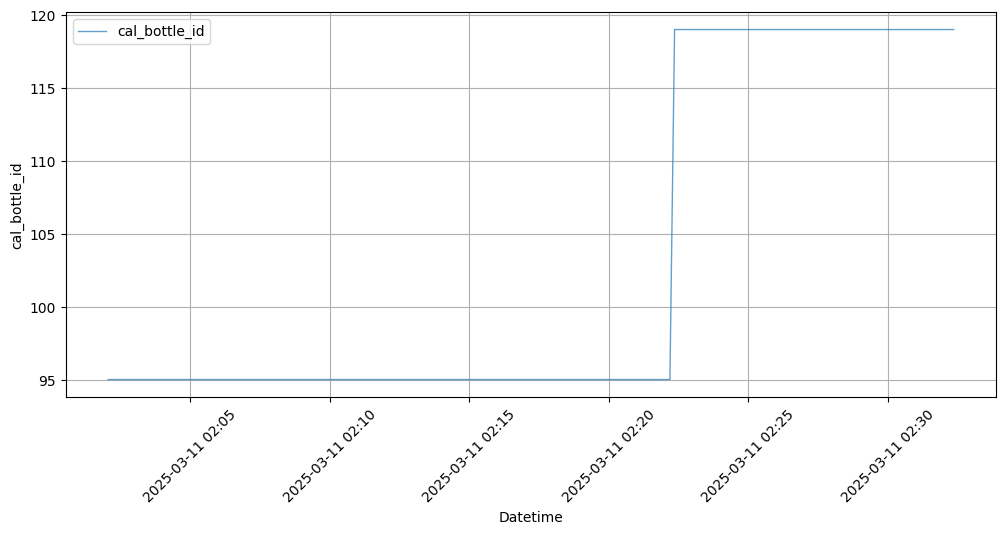

In [7]:
plot_column(df_c,"datetime","CO2_out_of_sensor")
plot_column(df_c,"datetime","cal_sht45_humidity")
plot_column(df_c,"datetime","cal_bottle_id")

Fragen

- Was seht ihr auf den Graphen?

- Was f√ºr einen Hintergrund hat die Ver√§nderung der relativen Luftfeuchtigkeit?

- Wie kann man sich das im realen System vorstellen?

# üß™ Praktiksche √úbung 3

In dieser √úbung arbeiten wir mit Daten, die w√§hrend einer Kalibrierung aufgenommen wurden. Ziel ist es Parameter zu finden, die eine stabile Auswertung beider Messungen zu erhalten und das initiale Trocknen des Luftkanals zuverl√§ssig zu entfernen.

‚úÖ Aufgabe:

- Ermittle den Mean und den Median f√ºr die Kalbrationen mit den Kalibrierflaschen 119 und 95 
- Ver√§ndere die Parameter `cut_from_start` und `cut_from_end`, um die Trocknung des Luftkanals stabil zu entfernen

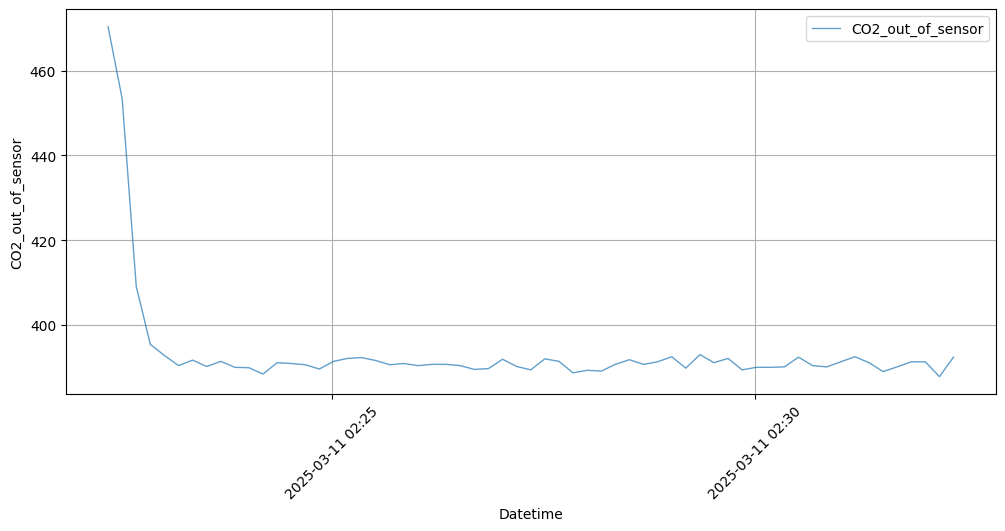

In [8]:
## Ver√§ndere nachfolgende Parameter
bottle_id = 119 # 119 or 95
##

df_bottle = df_c.filter(pl.col("cal_bottle_id") == bottle_id)

plot_column(df_bottle,"datetime","CO2_out_of_sensor")

Median: 390.7, Mean: 393.43934426229504


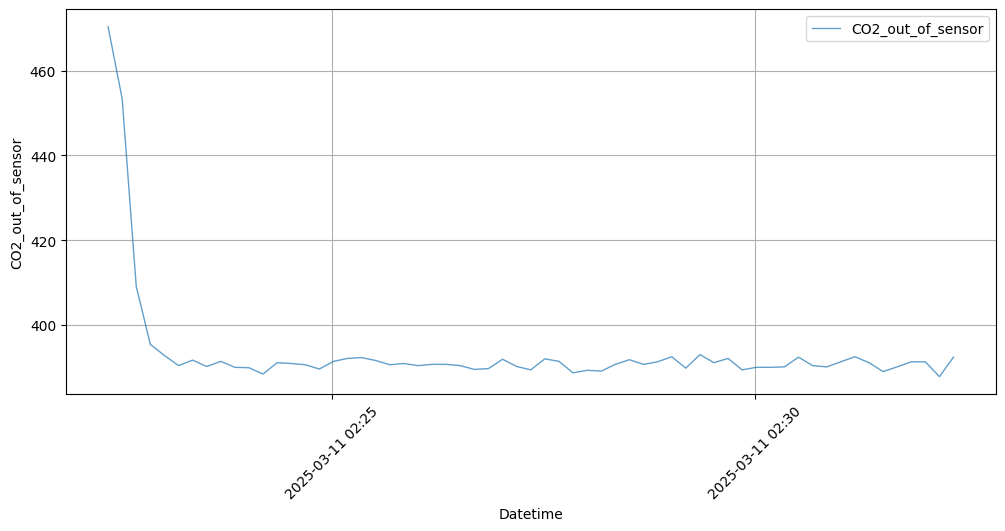

In [49]:
## Ver√§ndere nachfolgende Parameter
cut_from_start = 0 #Percent
cut_from_end = 0 #Percent
##

df_bottle_trimmed = trim_rows(df_bottle, cut_from_start, cut_from_end)

median, mean = median_and_mean(df_bottle_trimmed, "CO2_out_of_sensor")
print(f"Median: {median}, Mean: {mean}")

plot_column(df_bottle_trimmed,"datetime", "CO2_out_of_sensor")

Fragen

- Was ist stabiler der Median oder der Mean? Wieso ist das der Fall?

- Welchen Wert hat der Sensor f√ºr die Flasche 95 und 119 gemessen?

- Wieso ist es sinnvoll hier die Kalibrierdauer zu beschneiden?

---

# Kalibrierung der CO‚ÇÇ-Messungen aus Medianwerten

In dieser √úbung verwendet ihr zwei Kalibrierflaschen, um zuerst den Offset mittels einer 1-Punkt-Kalibrierung zu bestimmen und anschlie√üend den Slope sowie den Intercept √ºber eine 2-Punkt-Kalibrierung zu berechnen.

## Referenzwerte

- **Kalibrierflasche 119:** Tats√§chlicher CO‚ÇÇ-Wert = 403.04 ppm  
- **Kalibrierflasche 95:** Tats√§chlicher CO‚ÇÇ-Wert = 522.34 ppm



## 1-Punkt-Kalibrierung: Bestimmung des Offsets

Zun√§chst wird der Offset an einem einzelnen Referenzpunkt ermittelt. Hierbei verwendet ihr den Median der Messungen mit jeweils einer der Kalibrierflaschen.

Die Berechnung erfolgt nach der Formel:

$$
\text{Offset} = \text{Gemessener Median} - \text{Tats√§chlicher Wert}
$$




## 2-Punkt-Kalibrierung: Berechnung von Slope und Intercept

F√ºr eine genauere Kalibrierung nutzt ihr beide Referenzflaschen. Ihr bestimmt den Median der Messwerte f√ºr jede Flasche:

- $M_{95}$ bezeichnet den Median der Messungen an **Kalibrierflasche 95**.
- $M_{119}$ bezeichnet den Median der Messungen an **Kalibrierflasche 119**.

Unter der Annahme eines linearen Verhaltens der CO‚ÇÇ Sensors zwischen den gemessenen Median Werten und dem tats√§chlichen CO‚ÇÇ-Wert gilt:

$$
\text{Tats√§chlicher Wert} = m \times (\text{Gemessener Median}) + b
$$

Daraus ergeben sich f√ºr die beiden Kalibrierflaschen die Gleichungen:

$$
522.34 = m \cdot M_{95} + b
$$

$$
403.04 = m \cdot M_{119} + b
$$

### Berechnung des Slopes \( m \)

Um \( m \) zu ermitteln, subtrahiert ihr die Gleichung f√ºr **Kalibrierflasche 119** von der Gleichung f√ºr **Kalibrierflasche 95**:

$$
522.34 - 403.04 = m \cdot \left( M_{95} - M_{119} \right)
$$

Das vereinfacht sich zu:

$$
m = \frac{119.30}{M_{95} - M_{119}}
$$

### Berechnung des Intercepts \( b \)

Nachdem \( m \) bekannt ist, kann \( b \) aus einer der beiden Gleichungen berechnet werden, beispielsweise:

$$
b = 522.34 - m \cdot M_{95}
$$

# üß™ Praktische √úbung 4

‚úÖ Aufgabe:

- Berechnet die Offsets f√ºr die 1-Punkt Kalbrierung
- Berechnet den Slope und Intercept f√ºr die 2-Punkt Kalbrierung

In [50]:
#Beispiel Python Berechnung

(100 + 50) / 2

75.0

In [51]:
# Berechnung: Offset 119 (1-Punkt Kalibrierung)

In [52]:
# Berechnung: Offset 95 (1-Punkt Kalibrierung)

In [53]:
# Berechnung: Slope (2-Punkt Kalibrierung)

In [54]:
# Berechnung: Intercept (2-Punkt Kalibrierung)

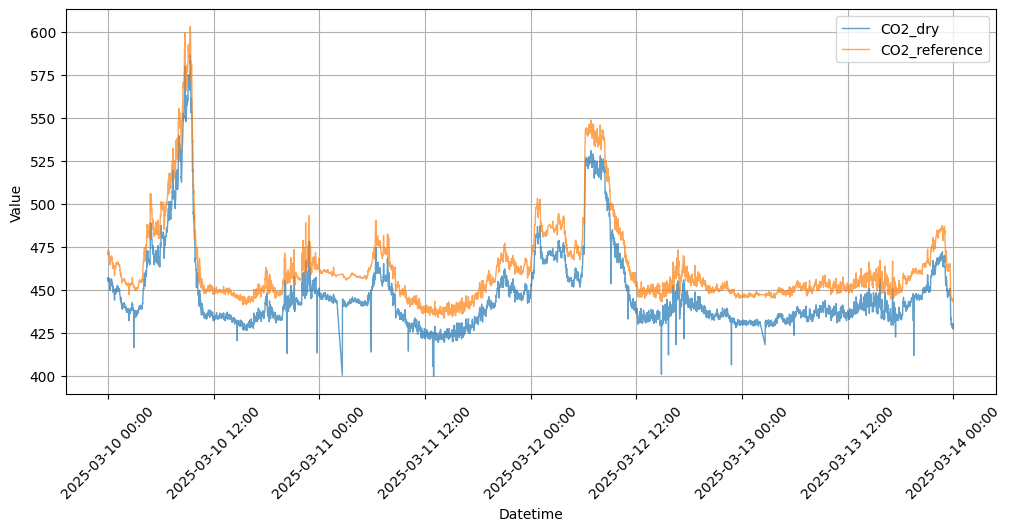

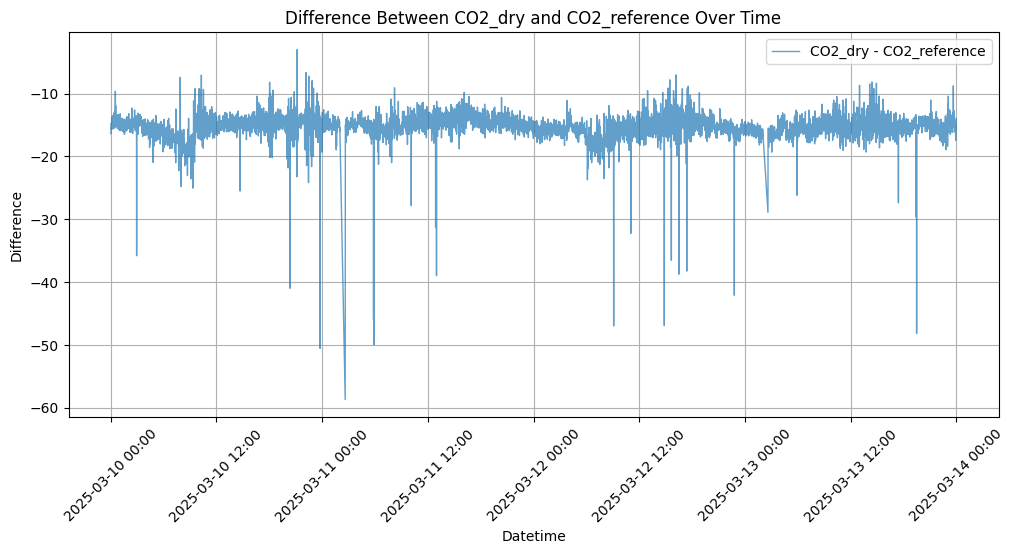

In [9]:
## Ver√§ndere nachfolgende Parameter
intercept = 0.0
slope =  1.0
##

df_plot = df.with_columns(pl.col("CO2_dry" ) * slope + intercept)

plot_columns(df_plot,"datetime",["CO2_dry" , "CO2_reference"])
plot_column_difference(df_plot,"datetime",["CO2_dry", "CO2_reference"])

Fragen:

- An welchen Tag wurde die Kalibrierung durchgef√ºhrt?

- Wie representativ ist die Kalibrierung f√ºr die gesamte Zeitdauer?

- Erwartet ihr, dass die Korrekturfaktoren f√ºr die Kalibrierung √ºber l√§ngere Zeit stabil bleiben? 

- Was versteht man unter Sensor Drift?